<a href="https://colab.research.google.com/github/Smartsie/Playground/blob/master/PhotoArt_Autoencoder2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Autoencoders

In [188]:
!pip install umap-learn
!pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.2 MB/s 
     |████████████████████████████████| 1.1 MB 29.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=e66202505fc325b4b36603c8aca54b0201b684b0a3d2302a53c1bd94e16ad647
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=d41ad0e4bed3824cb109bcef216bf6187fdcdfff4b0a9ed894ad28593cbe11a4
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import random
from PIL import Image, ImageOps
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error,classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.layers import Input, ZeroPadding2D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import keras
#import umap
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load the dataset
To start, we load the data needed to fit the autoencoder. Each image in this dataset is 224x224 pixels. 

In [ ]:
training_dataset_location= "/content/gdrive/MyDrive/Python/PhotoArt/Training_Set/"

In [ ]:
# Find all the image files in the specified directory
image_files = glob.glob(training_dataset_location+"*.*")
categories=[]
# Create an empty list to store the images
images = []
# Loop through the list of image files
for file in image_files:
  # Open the image file
  img = Image.open(file)
  # Convert the image to a 3-channel image
  img = img.convert("RGB")
  # Convert the image data to a NumPy array
  image_array = np.array(img)
  # Add the image array to the list of images
  images.append(image_array)
  # Add file name in categories
  categories.append(file[-30:])

In [ ]:
# Create the label encoder
le = LabelEncoder()
# Fit the label encoder to the labels
le.fit(categories)
# Assign it to y
# Transform the labels to numeric values
y = le.transform(categories)

In [ ]:
# Scale to 1.0 is not needed for MobileNet. Keep the original size. 
# Add an axis for the channel
images_array = np.expand_dims(np.array(images), axis=-1)
# Split the images into a training set and a test set
X_train, X_test,y_train,y_test = train_test_split(images_array,y,test_size=0.05)


# MobileNet
In MobileNet, the maximum value for the channels is 255. MobileNet is a deep learning model designed for efficient image classification and recognition tasks, and it expects the input images to be in the same format as other image classification models, with pixel values ranging from 0 to 255.

MobileNet is designed to handle inputs with 3 color channels (RGB), and each channel represents one of the primary colors (red, green, or blue). The values for each channel range from 0 (absence of the color) to 255 (maximum intensity of the color).

For example, if you have an RGB image with dimensions (height, width, 3) and you want to represent a pure red pixel at position (i, j), the values for the channels would be (255, 0, 0). Similarly, a pure green pixel would be represented as (0, 255, 0) and a pure blue pixel would be (0, 0, 255).




In [ ]:
# Load the MobileNet model
#model = MobileNet(weights='imagenet', include_top=False)
#tfmodel = Model(inputs=model.input, outputs=model.layers[-1].output)
# Load the pre-trained CNN
model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Calculate the full latent space of the images
features=model.predict(X_train)
# Apply average pooling to the feature maps
features = keras.layers.GlobalAveragePooling2D()(features)
print("Latent space dimension: ",np.shape(features))
latent_space=features.numpy()
#latent_space=features.reshape(len(features),-1)

81/81 [==============================] - 12s 154ms/step
Latent space dimension:  (2565, 512)


# Load a test picture and look for similarities

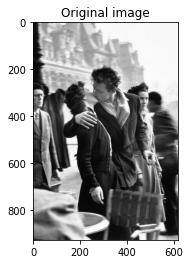

(926, 617, 3)


In [196]:
test_file="robert_doisneau__le_baiser__jpg_5254.jpg"
#test_file="Cyclistes-du-Dimanche.jpg"
#test_file="Cure.jpg"
#test_file="930x,1395-7-Pont-de-la-Tournelle,1951.jpeg"
#test_file="930x,1366-5-Cours-e-boxe-avec-Georges-Carpent.jpeg"
img = Image.open("/content/gdrive/MyDrive/Python/PhotoArt/Test_pictures/"+test_file)
# Convert the image to a 3-channel image. Keep encoding to 255, not 1.0
img = img.convert("RGB")
image_array = np.array(img)
#image_array=X_train[25]
plt.title('Original image')
plt.imshow(tf.squeeze(image_array))
plt.gray()
plt.show()
base_image=img
print(np.shape(image_array))


In [197]:
# crop_size of the crops we are going to take from the picture database
crop_size=224
# How many crops we generate for each picture
n_crops=100

In [198]:
test_array=[]
for i in range(0,n_crops):  
  # Generate a random rotation angle between -3 and 2 degrees
  angle = np.random.uniform(-3, 3)
  # Rotate the image
  rotated_image = base_image.rotate(angle)
  # Generate a random zoom factor between 0.5 and 2
  zoom = np.random.uniform(0.5, 2.0)
  # Resize the image using the zoom factor
  resized_image = rotated_image.resize((int(rotated_image.width * zoom), int(rotated_image.height * zoom)))
  # Get the width and height of the resized image
  #resized_image=image
  width, height = resized_image.size
  # Generate random coordinates for the top-left corner of the crop
  x1 = np.random.randint(0, width - crop_size)
  y1 = np.random.randint(0, height - crop_size)
  # Generate random coordinates for the bottom-right corner of the crop
  x2 = x1 + crop_size
  y2 = y1 + crop_size
  # Crop the image
  cropped_image = resized_image.crop((x1, y1, x2, y2))
  # Display the image
  #plt.imshow(cropped_image)
  #plt.gray()
  #plt.title('image '+str(i))
  #plt.show()
  test_array.append(np.array(cropped_image))
# Add an axis for the channel
test_array = np.expand_dims(test_array, axis=-1)

In [155]:
# Use a KNN Classifier to classify the pictures
# Split the data into training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(latent_space, y_train, stratify=y_train, test_size=0.2,random_state=123)
# Create a KNN classifier
#knn = KNeighborsClassifier(n_neighbors=4)
knn = Pipeline([
#    ('pca', PCA(0.8)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])
# Train the classifier using the training data
knn.fit(X_train2, y_train2)
# Test the classifier using the test data
report = classification_report(y_test2, knn.predict(X_test2))
print(report)

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        19
           1       0.86      0.95      0.90        19
           2       0.86      0.95      0.90        19
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        18
           5       0.89      0.85      0.87        20
           6       0.94      0.84      0.89        19
           7       0.93      0.74      0.82        19
           8       0.89      0.84      0.86        19
           9       1.00      0.95      0.97        19
          10       0.82      0.95      0.88        19
          11       0.86      1.00      0.93        19
          12       0.95      0.95      0.95        19
          13       1.00      1.00      1.00        19
          14       0.95      1.00      0.97        19
          15       0.92      0.63      0.75        19
          16       0.75      0.95      0.84        19
          17       1.00    

# Transform the data with MobileNet & predict classes

In [199]:
# Calculate latent space of the test pictures
latent_test=model.predict(test_array)
#latent_test=latent_test.reshape(len(latent_test),-1)
# Apply average pooling to the feature maps
features = keras.layers.GlobalAveragePooling2D()(latent_test)
print("Latent space dimension: ",np.shape(features))
latent_test=features.numpy()
# For each picture, calculate the classes
classes=knn.predict(latent_test)

4/4 [==============================] - 1s 453ms/step
Latent space dimension:  (100, 512)


In [200]:
from collections import Counter
# Use the Counter class to count the frequency of each number
counter = Counter(classes)
# Get the top 5 most common numbers
top_five = counter.most_common(20)
print(top_five)
most_common_numbers = [num for num, count in top_five]


[(14, 22), (17, 17), (8, 11), (24, 9), (16, 7), (20, 6), (22, 4), (2, 4), (7, 4), (19, 4), (11, 3), (12, 3), (0, 2), (6, 1), (1, 1), (5, 1), (21, 1)]


In [201]:
# Print most likely class
for i in range(0,3):
  result=int(most_common_numbers[i])
  picture_name=le.inverse_transform([result])
  print('Most likely pic is ',picture_name)


Most likely pic is  ['Robion-le-berger,juin-195.jpeg']
Most likely pic is  ['championnat-de-boules-195.jpeg']
Most likely pic is  ['71-13-Stade-de-Rugby,1964.jpeg']


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 10.9 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp38-cp38-linux_x86_64.whl size=396893 sha256=02cd646892ebf4cda28a7b770ac666e4514d6bd75893d4d0d944332dff329afa
  Stored in directory: /root/.cache/pip/wheels/f9/93/19/30511c4a9ae6b4937455a134c34a39e13943e2c6f46fcd2ed2
Successfully built annoy


In [205]:
import annoy
n=np.shape(X_train2)[1]
# Create an Annoy index with 10 trees and Euclidean distance
index = annoy.AnnoyIndex(n, 'angular')
# Add some data points to the index
for i in range(len(X_train2)):
  index.add_item(i, X_train2[i])
# Build the index
index.build(n)

True

In [206]:
classes=[]
for i in range(0,len(latent_test)):
  # Find the nearest neighbors of a query point
  nn = index.get_nns_by_vector(latent_test[i], 10)
  classes.append(nn)
classes=np.array(classes).ravel()

In [207]:
classes=[y_train2[i] for i in classes]

In [208]:
from collections import Counter
# Use the Counter class to count the frequency of each number
counter = Counter(classes)
# Get the top 5 most common numbers
top_five = counter.most_common(3)
print(top_five)
most_common_numbers = [num for num, count in top_five]
[le.inverse_transform([y_train2[i]]) for i in most_common_numbers]

[(14, 205), (17, 143), (24, 89)]


[array(['1-Catch-Salle-Wagram_607p.jpeg'], dtype='<U30'),
 array(['es-24-heures-du-Mans,1953.jpeg'], dtype='<U30'),
 array(['entral-sporting-club-1945.jpeg'], dtype='<U30')]

In [189]:
import plotly.express as px
import pandas as pd


In [190]:
from sklearn.manifold import Isomap, TSNE
import matplotlib.cm as cm
import umap
# Show the closes pictureswhere predict_proba of the main class is >0.7
reducer = umap.UMAP(n_components=2)
X_transformed = reducer.fit_transform(X_train2)
colormap = cm.get_cmap('gist_ncar', len(np.unique(y_train2)))


In [191]:
df=pd.DataFrame()
df['x']=X_transformed[:,0]
df['y']=X_transformed[:,1]
df['Class']=y_train2

In [195]:
px.scatter(df,x="x",y="y",color="Class",color_discrete_sequence=df["Class"])

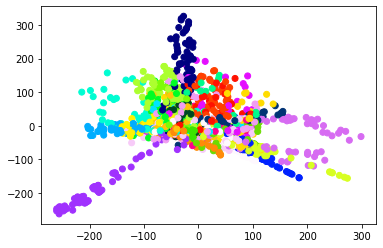

In [178]:
plt.scatter(X_transformed[:,0],X_transformed[:,1],c=colormap(y_train2))
plt.show()

In [ ]:
len(image_files)

160

In [ ]:
dot_prod=[]
for i in range(0,len(vec)):
  dot_product=np.dot(tf.squeeze(latent_test),tf.squeeze(vec[i]))/(np.dot(tf.squeeze(latent_test),tf.squeeze(latent_test))+np.dot(tf.squeeze(vec[i]),tf.squeeze(vec[i])))
  dot_prod.append(dot_product)

In [ ]:
# Use this to just extract one latent space, just a reminder to use np.expand_dims...
random_index=21
# extract image of random!index in test set
x=X_test[random_index]
# calculate the transform
latent_test=model.predict(np.expand_dims(x, axis=0))


1/1 [==============================] - 0s 353ms/step


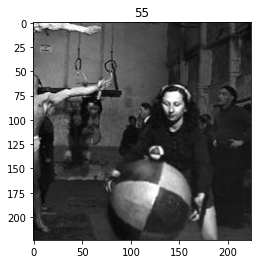

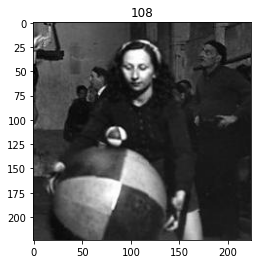

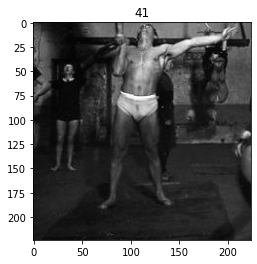

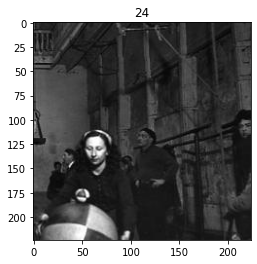

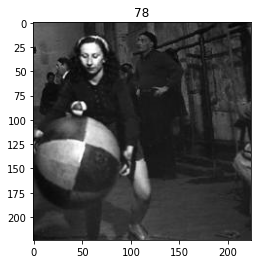

In [ ]:
for i in most_common_numbers:
  plt.title(str(i))
  plt.imshow(tf.squeeze(X_train[i]))
  plt.show()

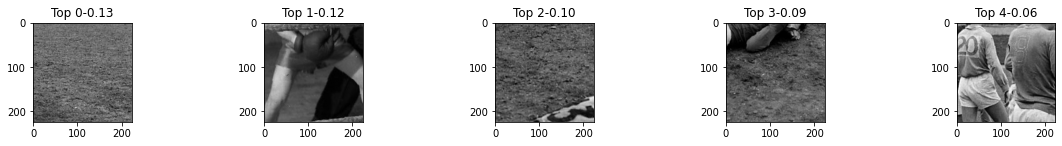

In [ ]:
Top5=np.argsort(dot_prod)[-5:][::-1]
#Display the image
plt.figure(figsize=(20, 4))
for i in range(0,len(Top5)):
  ax = plt.subplot(2, len(Top5), i + 1)
  plt.title("Top "+str(i)+ "-"+str(dot_prod[Top5[i]])[0:4])
  plt.imshow(tf.squeeze(X_train[Top5[i]]))
plt.show()

In [ ]:
# Skip from here
from collections import Counter
# Use the Counter class to count the frequency of each number
counter = Counter(indexes)
# Get the top 5 most common numbers
top_five = counter.most_common(5)
print(top_five)
most_common_numbers = [num for num, count in top_five]
print(most_common_numbers)

[(55, 50), (108, 50), (41, 50), (24, 50), (78, 50)]
[55, 108, 41, 24, 78]


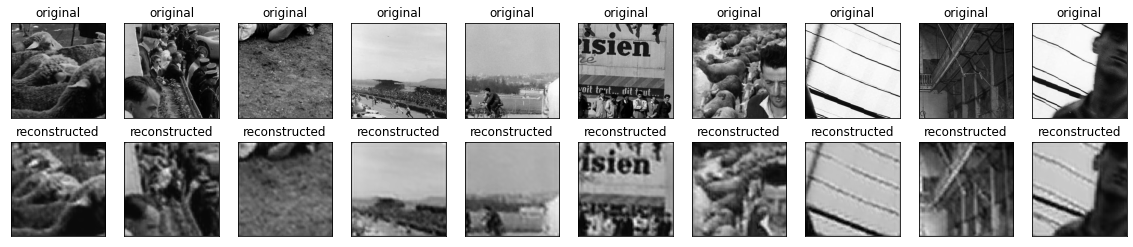

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    index=np.random.randint(0,len(X_test))
    plt.imshow(tf.squeeze(X_test[index]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    # Predict the image
    image=tf.squeeze(autoencoder(X_test[index:index+1]))
    # Normalize the image between 0 and 1
    image = (image - np.min(image)) / (np.max(image)- np.min(image))
    plt.imshow(image)
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [ ]:
Closest_pics_idx=[]
Pics_to_check=10
# For each image, generate the latent space
for i in range(0,len(test_array)):
  latent_test=model.predict(np.expand_dims(test_array[i], axis=0))
  # Calculate Dot product
  dot_prod=[]
  for j in range(0,len(latent_space_training_set)):
    x_=np.dot(tf.squeeze(latent_test.ravel()),tf.squeeze(latent_space_training_set[j].ravel()))/(np.dot(tf.squeeze(latent_test.ravel()),tf.squeeze(latent_test.ravel()))+np.dot(tf.squeeze(latent_space_training_set[j].ravel()),tf.squeeze(latent_space_training_set[j].ravel())))
    #x_=-mean_squared_error(latent_test.ravel(),latent_space_training_set[j].ravel())
    dot_prod.append(x_)
  # Calculate closest images Top N
  TopN=np.argsort(dot_prod)[-Pics_to_check:][::-1]
  Closest_pics_idx.append(TopN)
indexes=np.array(Closest_pics_idx).ravel()

1/1 [==============================] - 0s 16ms/step


In [ ]:
class DisplayImageCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    idx_list=[50,200,300]
    plt.figure(figsize=(20, 2))
    for i in range(0,len(idx_list)):
      idx=idx_list[i]
      # Predict the image
      image=tf.squeeze(autoencoder(X_train[idx:idx+1]))
      # Normalize the image between 0 and 1
      image = (image - np.min(image)) / (np.max(image)- np.min(image))
      # Plot the image
      ax = plt.subplot(1, 6, 2*i+1)
      plt.imshow(tf.squeeze(X_train[idx]))
      ax = plt.subplot(1, 6, 2*i+2)
      plt.imshow(image)
    plt.show()
    #clear_output(wait=True)


In [ ]:
def encoded_image(img):
  enc=tf.squeeze(encoder(img)).numpy().ravel()
  return enc

In [ ]:
vec=[]
for i in range(0,len(X_train)):
#  vec.append(encoded_image(X_train[i:i+1]))
  vec.append(encoded_image(X_train[i].reshape(1,256,256)))

In [ ]:
random_index=202
# extract image of random!index in test set
img_test=X_test[random_index]
# calculate the transform
latent_test=encoded_image(X_test[random_index:random_index+1])

In [ ]:
dot_prod=[]
for i in range(0,len(vec)):
  x=np.dot(latent_test,vec[i])/(np.dot(latent_test,latent_test)+np.dot(vec[i],vec[i]))
  dot_prod.append(x)

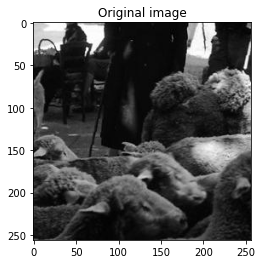

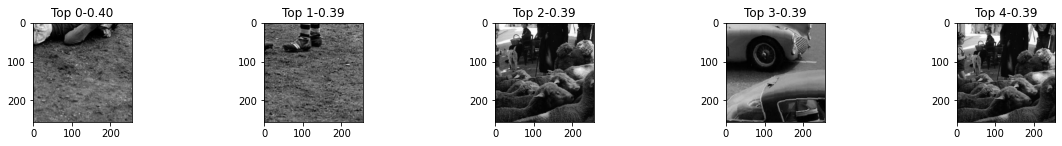

In [ ]:
Top5=np.argsort(dot_prod)[-5:][::-1]
#Display the image
plt.title('Original image')
plt.imshow(tf.squeeze(img_test))
plt.gray()
plt.figure(figsize=(20, 4))
for i in range(0,len(Top5)):
  ax = plt.subplot(2, len(Top5), i + 1)
  plt.title("Top "+str(i)+ "-"+str(dot_prod[Top5[i]])[0:4])
  plt.imshow(tf.squeeze(X_train[Top5[i]]))
plt.show()

In [ ]:
# Next
#Take a random image
#Make 100 samples from it (crop, zoom, etc...)
#Evaluate each of them
#make a distribution of most frequent proximity


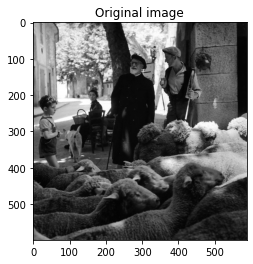

In [ ]:
#test_file="robert_doisneau__le_baiser__jpg_5254.jpg"
#test_file="Cyclistes-du-Dimanche.jpg"
test_file="Cure.jpg"
image = Image.open("/content/gdrive/MyDrive/Python/PhotoArt/Test_pictures/"+test_file)
# Convert the image data to a NumPy array
image=ImageOps.grayscale(image)
image_array = np.array(image)
plt.title('Original image')
plt.imshow(tf.squeeze(image_array))
plt.gray()
plt.show()

In [ ]:
# crop_size of the crops we are going to take from the picture database
crop_size=256
# How many crops we generate for each picture
n_crops=100

In [ ]:
test_array=[]
for i in range(0,n_crops):  
  # Generate a random rotation angle between -3 and 2 degrees
  angle = np.random.uniform(-3, 3)
  # Rotate the image
  rotated_image = image.rotate(angle)
  # Generate a random zoom factor between 0.5 and 2
  zoom = np.random.uniform(0.5, 2)
  # Resize the image using the zoom factor
  resized_image = rotated_image.resize((int(rotated_image.width * zoom), int(rotated_image.height * zoom)))
  # Get the width and height of the resized image
  #resized_image=image
  width, height = resized_image.size
  # Generate random coordinates for the top-left corner of the crop
  x1 = np.random.randint(0, width - crop_size)
  y1 = np.random.randint(0, height - crop_size)
  # Generate random coordinates for the bottom-right corner of the crop
  x2 = x1 + crop_size
  y2 = y1 + crop_size
  # Crop the image
  cropped_image = resized_image.crop((x1, y1, x2, y2))
  # Display the image
  # Save the cropped image to the save folder
  test_array.append(np.array(cropped_image))
# Add an axis for the channel
test_array = np.expand_dims(test_array, axis=-1)/255.

In [ ]:
Closest_pics_idx=[]
Pics_to_check=100
# For each image, generate the latent space
for i in range(0,len(test_array)):
  #plt.imshow(tf.squeeze(test_array[i]))
  #plt.show()
  # calculate the transform
  #latent_test=encoded_image(test_array[i])
  latent_test=tf.squeeze(encoder(test_array[i].reshape(1,256,256))).numpy().ravel()
  # Calculate Dot product
  dot_prod=[]
  for j in range(0,len(vec)):
    x=np.dot(latent_test,vec[j])/(np.dot(latent_test,latent_test)+np.dot(vec[j],vec[j]))
    dot_prod.append(x)
  # Calculate closest images Top N
  TopN=np.argsort(dot_prod)[-Pics_to_check:][::-1]
  Closest_pics_idx.append(TopN)
indexes=np.array(Closest_pics_idx).ravel()

In [ ]:
from collections import Counter
# Use the Counter class to count the frequency of each number
counter = Counter(indexes)
# Get the top 5 most common numbers
top_five = counter.most_common(10)
print(top_five)
most_common_numbers = [num for num, count in top_five]
print(most_common_numbers)

[(42, 71), (459, 71), (655, 69), (232, 66), (121, 64), (783, 64), (58, 63), (534, 62), (18, 62), (712, 61)]
[42, 459, 655, 232, 121, 783, 58, 534, 18, 712]


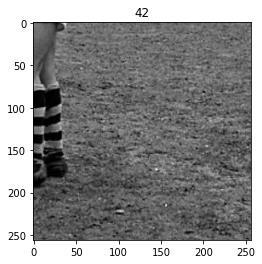

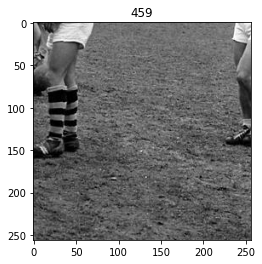

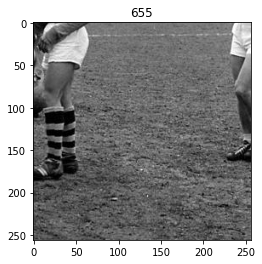

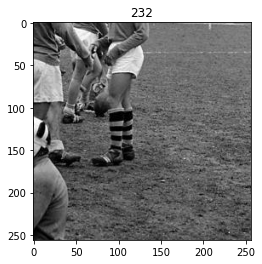

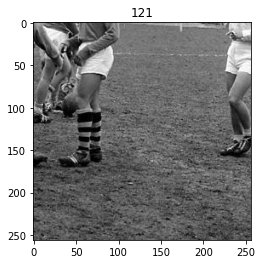

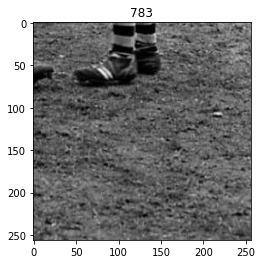

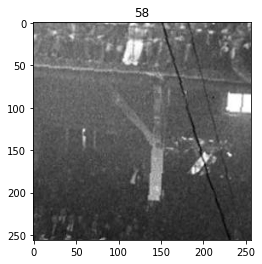

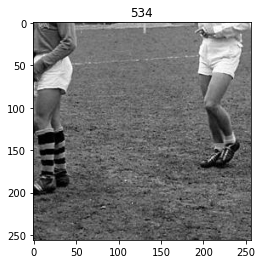

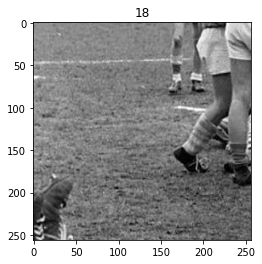

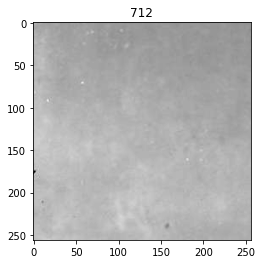

In [ ]:
for i in most_common_numbers:
  plt.title(str(i))
  plt.imshow(tf.squeeze(X_train[i]))
  plt.show()

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG. 

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial. 

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier. 

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

## Next steps

To learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow. To learn more about the basics, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet. For more details, check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
